We consider the system of particle species A, B and C that undergo reactions $A + B\rightleftharpoons C$ and also have optional volume exclusion effects due to repulsive potentials between all particles. A and B Particles will be initially uniformly distributed in a periodic box and no C particles are present. 

We first demonstrate how the concentration of particles evolves in time and compares to a description by the law of mass action (LMA). This demonstrates that ReaDDy produces exact results when parameters are in the well-mixed regime. We also show that including a repulsive potential between all particles, but not changing the intrinsic reaction rates, will lead to different macroscopic reaction kinetics.

The focus of this demonstration is the measurement of computation time. In particular we observe the computation time $\tau$ per particle and per integration step. The system is simulated for different initial particle numbers, such that the density is constant.

In [2]:
import os
import numpy as np

import readdy
ut = readdy.units

In [3]:
readdy.__version__

'v1.0.1-0'

Add species A, B and C to the system. Diffusion constants are chosen to represent the size of particles A, B and C according to the Einstein-Stokes relation

$$D_i = \frac{k_B T}{6\pi\eta r_i}$$

where $D_i$ is the diffusion coefficient of species $i$ and $r_i$ is its radius. $\eta$ is the viscosity of a cellular environment, i.e. mostly water. $k_B T$ is the termal energy, here we choose it to represent a system at room temperature.

Note that in ReaDDy, the concept of a particle radius does not exist. The volume of a particle only becomes important when setting the reaction radius of a reaction or when setting the interaction distance of a interaction potential. However in modeling a certain system, we have particles with certain sizes in mind. To implement these, one can set the radii of particles outside of ReaDDy and use them to choose the reaction radii and interaction distances.

In [4]:
particle_radii = {"A": 1.5, "B": 3., "C": 3.12}  # in nanometers
dt = 1e-1 * ut.nanosecond

In [5]:
def get_system(with_repulsion):
    system = readdy.ReactionDiffusionSystem(
        box_size=[60., 60., 60.],
        temperature=293.,
        unit_system={"length_unit": "nanometer", "time_unit": "nanosecond", "energy_unit": "kilojoule / mol"}
    )
    
    system.add_species("A", diffusion_constant=143.1 * ut.micrometer ** 2 / ut.second)
    system.add_species("B", diffusion_constant=71.6 * ut.micrometer ** 2 / ut.second)
    system.add_species("C", diffusion_constant=68.82 * ut.micrometer ** 2 / ut.second)
    
    if with_repulsion:
        force_constant = 10. * ut.kilojoule / ut.mol / (ut.nanometer ** 2)
    else:
        force_constant = 0. * ut.kilojoule / ut.mol / (ut.nanometer ** 2)
    if force_constant.magnitude > 0.:
        all_pairs = [("A","A"), ("B","B"), ("C", "C"), ("A", "B"), ("A", "C"), ("B", "C")]
        for pair in all_pairs:
            distance = particle_radii[pair[0]] + particle_radii[pair[1]]
            system.potentials.add_harmonic_repulsion(pair[0], pair[1], force_constant, 
                                                     interaction_distance=distance)
    return system

Particles can undergo the two reactions $A + B \rightarrow C$ and $C \rightarrow A + B$. Note that the particles radii are chosen, such that the total volume of particles is conserved in this reaction, i.e.

$$ r_A^3 + r_B^3 = r_C^3 $$

The reaction radius $R$ is chosen as $R=r_A + r_B$. This is used as the maximum distance of educts in the Fusion reaction as well as the distance at which products will be placed in the Fission reaction.

In [6]:
reaction_radius = particle_radii["A"] + particle_radii["B"]
def configure_reactions(system):
    system.reactions.add_fusion("fusion", "A", "B", "C",
                                rate=1e6 / ut.second,
                                educt_distance=reaction_radius * ut.nanometer)
    system.reactions.add_fission("fission", "C", "A", "B",
                                 rate=5e4 / ut.second,
                                 product_distance=reaction_radius * ut.nanometer)

In [7]:
number_a = 509
number_b = 509
def simulate(system, output_file):
    simulation = system.simulation(kernel="SingleCPU")
    simulation.output_file = output_file
    simulation.reaction_handler = "UncontrolledApproximation"

    edge_length = system.box_size[0]
    initial_positions_a = np.random.random(size=(number_a, 3)) * edge_length - .5 * edge_length
    initial_positions_b = np.random.random(size=(number_b, 3)) * edge_length - .5 * edge_length
    simulation.add_particles("A", initial_positions_a)
    simulation.add_particles("B", initial_positions_b)

    simulation.observe.number_of_particles(stride=1, types=["A", "B", "C"])

    if os.path.exists(simulation.output_file):
        os.remove(simulation.output_file)

    n_steps = int(10000. / dt.magnitude)  # simulate to 10 microseconds
    simulation.run(n_steps=n_steps, timestep=dt)

In [8]:
system_with_repulsion = get_system(True)
configure_reactions(system_with_repulsion)
system_without_repulsion = get_system(False)
configure_reactions(system_without_repulsion)

In [9]:
outfile_with_repulsion = "cytosolic_reactions_with_repulsion.h5"
simulate(system_with_repulsion, outfile_with_repulsion)

Configured kernel context with:
--------------------------------
 - kBT = 2.43614
 - periodic b.c. = (true, true, true)
 - box size = (60, 60, 60)
 - particle types:
     *  particle type "C" with D=0.06882
     *  particle type "A" with D=0.1431
     *  particle type "B" with D=0.0716
 - potentials of order 2:
     * for types "B" and "B"
         * Harmonic repulsion with force constant k=10
     * for types "A" and "B"
         * Harmonic repulsion with force constant k=10
     * for types "A" and "A"
         * Harmonic repulsion with force constant k=10
     * for types "C" and "C"
         * Harmonic repulsion with force constant k=10
     * for types "A" and "C"
         * Harmonic repulsion with force constant k=10
     * for types "B" and "C"
         * Harmonic repulsion with force constant k=10
 - unimolecular reactions:
     * Fission C -> A + B with a rate of 5e-05, a product distance of 4.5, and weights 0.5 and 0.5
 - bimolecular reactions:
     * Fusion A + B -> C with a

In [10]:
outfile_without_repulsion = "cytosolic_reactions_without_repulsion.h5"
simulate(system_without_repulsion, outfile_without_repulsion)

Configured kernel context with:
--------------------------------
 - kBT = 2.43614
 - periodic b.c. = (true, true, true)
 - box size = (60, 60, 60)
 - particle types:
     *  particle type "C" with D=0.06882
     *  particle type "A" with D=0.1431
     *  particle type "B" with D=0.0716
 - unimolecular reactions:
     * Fission C -> A + B with a rate of 5e-05, a product distance of 4.5, and weights 0.5 and 0.5
 - bimolecular reactions:
     * Fusion A + B -> C with a rate of 0.001, an educt distance of 4.5, and weights 0.5 and 0.5



Obtain output

In [11]:
c = dict()

traj_with_repulsion = readdy.Trajectory(outfile_with_repulsion)
times, counts = traj_with_repulsion.read_observable_number_of_particles()
concentrations = counts / system_with_repulsion.box_volume.magnitude
c["w/ repulsion"] = {"A": concentrations[:, 0], "B": concentrations[:, 1], "C": concentrations[:, 2]}

traj_without_repulsion = readdy.Trajectory(outfile_without_repulsion)
times2, counts2 = traj_without_repulsion.read_observable_number_of_particles()
concentrations2 = counts2 / system_without_repulsion.box_volume.magnitude
c["w/o repulsion"] = {"A": concentrations2[:, 0], "B": concentrations2[:, 1], "C": concentrations2[:, 2]}
times = times * dt.magnitude

Under the assumption that the system is well mixed (particles encounter often, but rarely react), and there are no interaction potentials, that would obstruct particles in their free diffusion, one can approximate the macroscopic association rate $k_\mathrm{on}$ as

$$k_\mathrm{on} = \lambda_\mathrm{on} V_R $$

where $\lambda_\mathrm{on}$ is the intrinsic association rate and $V_R$ is the reaction volume available to a pair of particles A and B.

In [12]:
from scipy.integrate import odeint

lambda_on = 1e6 * 1e-9 # per nanosecond
reaction_volume = 4. / 3. * np.pi * reaction_radius**3
k_on = lambda_on * reaction_volume # dilute (large volume) and well mixed (fast diffusion) approximation
k_off = 5e4 * 1e-9 # per nanosecond
def f(x, _):
    result = np.zeros_like(x)
    delta = - k_on * x[0] * x[0] + k_off * x[1]
    result[0] = delta
    result[1] = -1. * delta
    return result

x_init = np.array([number_a, 0.]) / system_with_repulsion.box_volume.magnitude
ode_times = np.arange(0., 10000. , 1.) # in nanoseconds
ode_solution = odeint(f, x_init, t=ode_times)

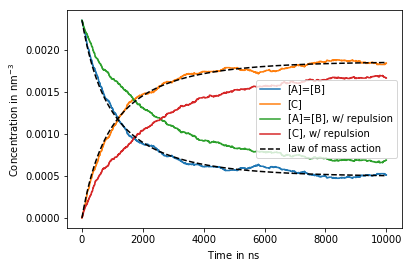

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(times, c["w/o repulsion"]["A"], label="[A]=[B]")
plt.plot(times, c["w/o repulsion"]["C"], label="[C]")
plt.plot(times, c["w/ repulsion"]["A"], label="[A]=[B], w/ repulsion")
plt.plot(times, c["w/ repulsion"]["C"], label="[C], w/ repulsion")
plt.plot(ode_times, ode_solution[:, 0], "k--", label="law of mass action")
plt.plot(ode_times, ode_solution[:, 1], "k--")
plt.legend(loc="best")
plt.xlabel(r"Time in $\mathrm{ns}$")
plt.ylabel(r"Concentration in $\mathrm{nm}^{-3}$")
plt.show()

__Performance__


The system shown above is simulated for constant densities but different number of particles. For the measurements we always have particle repulsion present. The computation time is measured for the different compute-kernels `SingleCPU` and `CPU`. The most important value is the computation time $\tau$ per particle and per integration step. This value is measured at the highest number of particles as it usually saturates when load-balancing improves. An exception is the legacy Java version, which was measured at 1500 particles since it does not scale well. The measurements were performed on a machine equipped with a `Intel(R) Xeon(R) CPU E5-1630 v4 @ 3.70GHz` that has 8 logical CPUs, all of which were used for profiling the `CPU` compute-kernel.

$\tau$ - computation time per particle and per integration step

| ReaDDy version | $\tau$ SingleCPU  | $\tau$ CPU  |
|---|---| ---|
|java legacy(@1500 particles) | 3.77806e-06 | n.a. |
| v1.0.0-py36_7_g50d9ee5 | 2.11896e-06 s | 8.21963e-07 s |
| v1.0.0-py36_59_ga47c0048 | 1.43479e-06 s | 6.02905e-07 s |
| v1.0.1 | 1.23611e-06 s | 5.13914e-07 s |



![](scaling_cytosolic_reactions_v1.0.1_platypus.png)